In [276]:
# Libraries
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import random
import numpy as np

# Standard approach (de-identified experts)

In [4]:
class Linear_net_rej(nn.Module):
    '''
   (Mozannar & Sontag) Linear classifier and deferral for L_CE loss for binary response
   novel convex consistent surrogate loss
    '''
    def __init__(self, input_dim, out_dim):
        super(Linear_net_rej, self).__init__()
        # an affine operation: y = Wx + b
        self.fc = nn.Linear(input_dim, out_dim+1) # out: 0,1,2
        self.fc_rej = nn.Linear(input_dim, 1)
        torch.nn.init.ones_(self.fc.weight)
        torch.nn.init.ones_(self.fc_rej.weight)
        self.softmax = nn.Softmax(dim=0) # dim = 0 to get 0,1,2 as output

    def forward(self, x):
        out = self.fc(x)
        rej = self.fc_rej(x)
        #out = torch.cat([out,rej],1)
        out = self.softmax(out)
        return out

In [5]:
def reject_CrossEntropyLoss(outputs, h, labels, m, n_classes):
    '''
    (Mozannar & Sontag) Implmentation of L_{CE}^{\alpha}
        outputs: classifier and rejector model outputs
        h: cost of deferring to expert cost of classifier predicting (I_{m =y})
        labels: target
        m: cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        n_classes: number of classes/outputs
    '''    
    batch_size = outputs.size()[0]            # batch_size
    rc = torch.tensor([n_classes] * batch_size, dtype=torch.long)
    #labels = torch.tensor(labels, dtype=torch.long)
    labels = labels.clone().detach().long()
    outputs =  -h*torch.log2( outputs[range(batch_size), rc]) - m*torch.log2(outputs[range(batch_size), labels])   # pick the values corresponding to the labels
    return torch.sum(outputs)/batch_size

In [264]:
def run_classifier_rej(model, exp_heuristic, data_x, data_y, alpha, p, k):
    '''
    (Mozannar & Sontag) training script for L_{CE}
        model: classifier and rejector model
        data_x: input
        data_y: label
        alpha: hyperparam alpha for loss L_CE^{\alpha}
        p: probability of randomly selecting expert 1
    '''
    
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.5, 0.99), weight_decay=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(data_x)*100)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)


    for epoch in range(1):  # loop over the dataset multiple times
        inputs = torch.tensor(data_x)
        labels = torch.tensor(data_y)

        # split to create batch size
        x_batches = torch.split(inputs, 5)
        y_batches = torch.split(labels, 5) 

        loss_train = []

        for inputs, labels in zip(x_batches, y_batches):

            optimizer.zero_grad()

            # forward + backward + optimize
            rand_exp = random.choices([1, k], weights=[p, 1-p])[0] # randomly select expert k

            predicted = torch.tensor(exp_heuristic[rand_exp-1](inputs))  # get predictions from selected expert
            
            h = (predicted==labels)*1
            m = [0] * len(inputs) 
            for j in range (0,len(inputs)): # determines weights
                if h[j]:
                    m[j] = alpha
                else:
                    m[j] = 1

            h = h.clone().detach()
            m = torch.tensor(m)
            inputs = inputs.to(torch.float32)
            outputs = model(inputs)

            # Loss
            loss = reject_CrossEntropyLoss(outputs, h, labels, m, 2) # this is loss for classifier and rejector, 2 outputs
            loss.backward()
            optimizer.step()
            scheduler.step()
            loss_train.append(loss.item())

    plt.plot(loss_train, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()   

In [262]:
def classifier_rej(model, exp_heuristic, data_x, data_y, p, k, exp_instances):
    '''
    (Mozannar & Sontag) Test classifier and deferral model for L_{CE} loss
    '''
    correct = 0
    correct_sys = 0
    exp = [0]*k
    exp_total = [0]*k
    total = 0
    real_total = 0
    points = len(data_x)

    with torch.no_grad():
        inputs = torch.tensor(data_x)
        labels = torch.tensor(data_y)

        inputs = inputs.to(model.fc.weight.dtype)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) #0/1 (ML), 2 (defer to expert)
        predicted_exp = [torch.tensor(exp_heuristic(inputs)) for exp_heuristic in exp_heuristic]

        for i in range(len(inputs)):
            r = (predicted[i] == 2).item() # if 2, then defer to expert
            if r:
                rand_exp = random.choices([1, k], weights=[p, 1-p])[0] # randomly select expert for each point
                correct_sys += (predicted_exp[rand_exp-1][i] == labels[i]).item()
                exp[rand_exp-1] += (predicted_exp[rand_exp-1][i] == labels[i]).item()
                exp_total[rand_exp-1] += 1
                exp_instances[rand_exp-1].append(i)
            else: 
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()
                total += 1
        real_total += labels.size(0)

    print("system accuracy", 100 * correct_sys / real_total)
    print("total points:", points)
    print()

    for idx, (c, expert_total) in enumerate(zip(exp, exp_total)):
        print(f"Expert {idx+1} defer count:", expert_total)
        print(f"Expert {idx+1} defer percent:", 100 * expert_total / points if expert_total != 0 else 0)
        print(f"Expert {idx+1} correct predictions:", c)
        print(f"Expert {idx+1} accuracy:", 100 * c / (expert_total + 0.0002) if expert_total != 0 else 0)
        print()

    print("Not deferred to any expert count:", total)
    print("Not deferred percent:", 100 * total / points)
    print("Model correct predictions:", correct)
    print("Model accuracy:", 100 * correct / (total + 0.0001))

    print()
    overall_exp_total = sum(exp_total)
    overall_exp_correct = sum(exp)
    print("Overall expert count:", overall_exp_total)
    print("Overall expert defer percent:", 100 * overall_exp_total / points)
    print("Overall expert correct predictions:", overall_exp_correct)
    print("Overall expert accuracy:", 100 * overall_exp_correct / (overall_exp_total + 0.0001) if overall_exp_total != 0 else 0)

    return exp_instances

# Optimal approach

In [8]:
class Linear_net_rej_id(nn.Module):
    '''
   (Mozannar & Sontag) Linear classifier and deferral for L_CE loss for binary response
   novel convex consistent surrogate loss
    '''
    def __init__(self, input_dim, out_dim, k):
        super(Linear_net_rej_id, self).__init__()
        # an affine operation: y = Wx + b
        self.fc = nn.Linear(input_dim, out_dim+k) # out: 0,1,2,3
        self.fc_rej = nn.Linear(input_dim, 1)
        torch.nn.init.ones_(self.fc.weight)
        torch.nn.init.ones_(self.fc_rej.weight)
        self.softmax = nn.Softmax(dim=0) # dim = 0 to get 0,1,2,3 as output

    def forward(self, x):
        out = self.fc(x)
        rej = self.fc_rej(x)
        #out = torch.cat([out,rej],1)
        out = self.softmax(out)
        return out

In [9]:
def reject_CrossEntropyLoss_id(outputs, h, labels, m, n_classes):
    '''
    (Mozannar & Sontag) Implmentation of L_{CE}^{\alpha}
        outputs: classifier and rejector model outputs
        h: cost of deferring to expert k cost of classifier predicting (I_{m =y})
        labels: target
        m: cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        n_classes: number of classes, binary here
    '''    
    batch_size = outputs.size()[0]            # batch_size
    rc = torch.tensor([n_classes] * batch_size, dtype=torch.long)
    labels = labels.clone().detach().long()
    outputs_exp = [torch.zeros(batch_size) for _ in range(k)]

    for i in range(k):
        outputs_exp[i] = -h[i] * torch.log2(outputs[range(batch_size), rc]) - m[:, i] * torch.log2(outputs[range(batch_size), labels])

    outputs = sum(outputs_exp)  # Sum the losses from all experts
    
    return torch.sum(outputs) / batch_size

In [231]:
def run_classifier_rej_id(model, exp_heuristic, data_x, data_y, alpha, k):
    '''
    (Mozannar & Sontag) training script for L_{CE}
        model: classifier and rejector model
        data_x: input
        data_y: label
        alpha: expert 1 hyperparam alpha for loss L_CE^{\alpha} 
        beta: expert 2 hyperparam alpha for loss L_CE^{\beta} 
        p: probability of randomly selecting expert 1
    '''
    
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.08, betas = (0.75, .1), weight_decay=.2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(data_x)*100)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)

    for epoch in range(1):  # loop over the dataset multiple times
        inputs = torch.tensor(data_x)
        labels = torch.tensor(data_y)

        # split to create batch size
        x_batches = torch.split(inputs, 5)
        y_batches = torch.split(labels, 5) 

        loss_train = []

        for inputs, labels in zip(x_batches, y_batches):
            optimizer.zero_grad()

            predicted = [torch.tensor(expert(inputs)) for expert in exp_heuristic]

            h_list = [(expert_output == labels) * 1 for expert_output in predicted]

            m = torch.zeros(len(inputs), k)

            for j in range(len(inputs)):
                for i in range(k):
                    if h_list[i][j]:
                        m[j][i] = alpha
                    else:
                        m[j][i] = 1

            h_list = [h.clone().detach() for h in h_list]
            m = m.clone().detach()

            inputs = inputs.to(model.fc.weight.dtype)
            outputs = model(inputs)

            # Loss computation
            loss = reject_CrossEntropyLoss_id(outputs, h_list, labels, m, 2)
            loss.backward()
            optimizer.step()
            scheduler.step()
            loss_train.append(loss.item())

    plt.plot(loss_train, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()    

In [237]:
def classifier_rej_id(model, exp_heuristic, data_x, data_y, k, exp_instances):
    '''
    (Mozannar & Sontag) Test classifier and deferral model for L_{CE} loss
    '''
    correct = 0
    correct_sys = 0
    exp = [0]*k
    exp_total = [0]*k
    total = 0
    real_total = 0
    points = len(data_x)

    with torch.no_grad():
        inputs = torch.tensor(data_x)
        labels = torch.tensor(data_y)

        inputs = inputs.to(torch.float32)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_exp = [torch.tensor(exp_heuristic(inputs)) for exp_heuristic in exp_heuristic]

        for i in range(len(inputs)):
            r = predicted[i].item() > 1  # if greater than 1, then defer to experts
            if r:
                expert_id = predicted[i].item() - 2  # expert index starts from 0
                correct_sys += (predicted_exp[expert_id][i] == labels[i]).item()
                exp[expert_id] += (predicted_exp[expert_id][i] == labels[i]).item()
                exp_total[expert_id] += 1
                exp_instances[expert_id].append(i)

            else:
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()
                total += 1
        real_total += labels.size(0)

    print("system accuracy", 100 * correct_sys / real_total)
    print("total points:", points)
    print()

    for idx, (c, expert_total) in enumerate(zip(exp, exp_total)):
        print(f"Expert {idx+1} defer count:", expert_total)
        print(f"Expert {idx+1} defer percent:", 100 * expert_total / points if expert_total != 0 else 0)
        print(f"Expert {idx+1} correct predictions:", c)
        print(f"Expert {idx+1} accuracy:", 100 * c / (expert_total + 0.0002) if expert_total != 0 else 0)
        print()

    print("Not deferred to any expert count:", total)
    print("Not deferred percent:", 100 * total / points)
    print("Model correct predictions:", correct)
    print("Model accuracy:", 100 * correct / (total + 0.0001))
    print()

    print()
    overall_exp_total = sum(exp_total)
    overall_exp_correct = sum(exp)
    print("Overall expert count:", overall_exp_total)
    print("Overall expert defer percent:", 100 * overall_exp_total / points)
    print("Overall expert correct predictions:", overall_exp_correct)
    print("Overall expert accuracy:", 100 * overall_exp_correct / (overall_exp_total + 0.0001) if overall_exp_total != 0 else 0)

    return exp_instances


# Keswani data

In [290]:
def getSyntheticDataset(total=1000):
    X, y, groups = [], [], []
    group_frac = 0.5

    N1 = 2000
    d = 2

    N2 = 500
    mu = np.array([random.random() for _ in range(d)])
    sig = [[0 for _ in range(d)] for _ in range(d)]
    for i in (range(d)):
        sig[i][i] = random.random() # 2D diagonal matrix with diagonal entries sampled from Unif[0,1]

    X = X + list(np.random.multivariate_normal(mu, sig, N2)) # 250, orange y = 0
    X = X + list(np.random.multivariate_normal(mu+2.5, sig, N2)) # 250, orange y = 1

    for _ in range(N2):
        groups.append(0)
        y.append(0)

    for _ in range(N2):
        groups.append(0)
        y.append(1)

    N3 = 500
    X = X + list(np.random.multivariate_normal(mu+5, sig, N3)) # 500, blue, y = 0,1

    for _ in range(N3):
        groups.append(1)

    for _ in range(N3):
        label = flip(0.5)
        y.append(label)

    N4 = 500
    X = X + list(np.random.multivariate_normal(mu+7.5, sig, N4)) # 500, green, y = 0,1

    for _ in range(N4):
        groups.append(2)

    for _ in range(N4):
        label = flip(0.5)
        y.append(label)
        
    return X, y, groups, mu, sig

In [13]:
def flip(p):
    return 1 if random.random() < p else 0

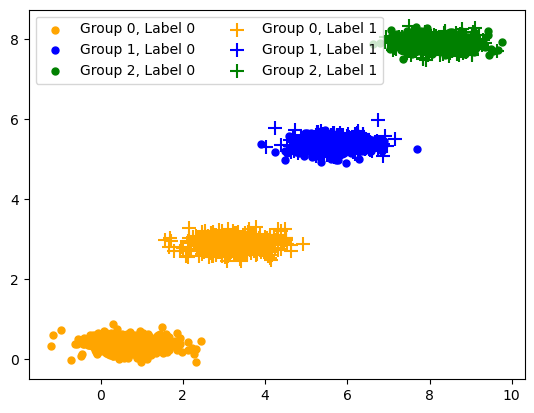

In [292]:
#Create the synthetic dataset

total=2000
X, y, groups, mu, sig = getSyntheticDataset(total)

import itertools
colors = ["orange", "blue", "green", "gray"]
markers = [".", "+"]

indices = list(range(total))
random.shuffle(indices)
# indices = indices[:500]

for label, group in itertools.product(np.unique(y), np.unique(groups)):
    x1 = [X[i][0] for i in indices if y[i]==label and groups[i]==group]
    x2 = [X[i][1] for i in indices if y[i]==label and groups[i]==group]
    
    leg = "Group " + str(group) + ", Label " + str(label)
    plt.scatter(x1, x2, c=colors[group], marker=markers[label], label=leg, s=100)
plt.legend(ncol=2)

- AI System: Orange
- Expert 1: Blue (some distribution)
- Expert 2: Green (some distribution)

In [297]:
X = torch.tensor(X)
y = torch.tensor(y)

In [298]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=456)

In [301]:
# Expert 1
exp_1 = DecisionTreeClassifier().fit(X[1000:1500], y[1000:1500])

# Expert 2
exp_2 = DecisionTreeClassifier().fit(X[1500:2000], y[1500:2000])

trained on their respective clusters

In [302]:
def expert1(inputs):
    return exp_1.predict(inputs)

def expert2(inputs):
    return exp_2.predict(inputs)

## Identity/Optimal
- we expect to see each expert performs ~100% and the overall system performance higher than the standard approach

/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/2435080426.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_x)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/2435080426.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data_y)


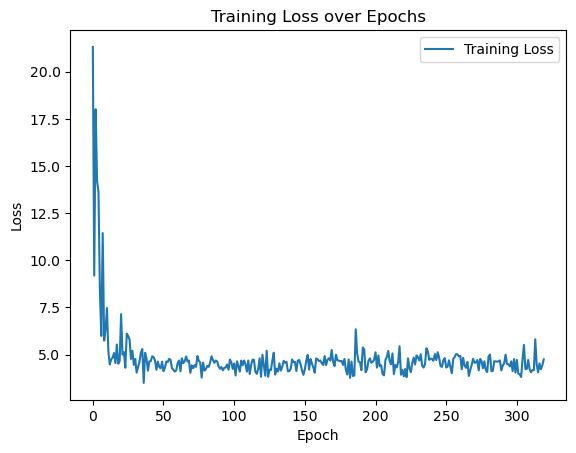

system accuracy 69.0
total points: 1600

Expert 1 defer count: 393
Expert 1 defer percent: 24.5625
Expert 1 correct predictions: 389
Expert 1 accuracy: 98.98213792257611

Expert 2 defer count: 209
Expert 2 defer percent: 13.0625
Expert 2 correct predictions: 209
Expert 2 accuracy: 99.99990430631166

Not deferred to any expert count: 998
Not deferred percent: 62.375
Model correct predictions: 506
Model accuracy: 50.70139772531085


Overall expert count: 602
Overall expert defer percent: 37.625
Overall expert correct predictions: 598
Overall expert accuracy: 99.3355316718386


/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/3250963421.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_x)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/3250963421.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data_y)


In [303]:
d = 2
experts = [expert1, expert2]
k = len(experts)
m = Linear_net_rej_id(d,2,k) # 2 inputs
alpha = 0

exp_index_train = [[] for _ in range(k)]

run_classifier_rej_id(m, experts, X_train, y_train, alpha, k)
exp1_index_train, exp2_index_train = classifier_rej_id(m, experts, X_train, y_train, k, exp_index_train)

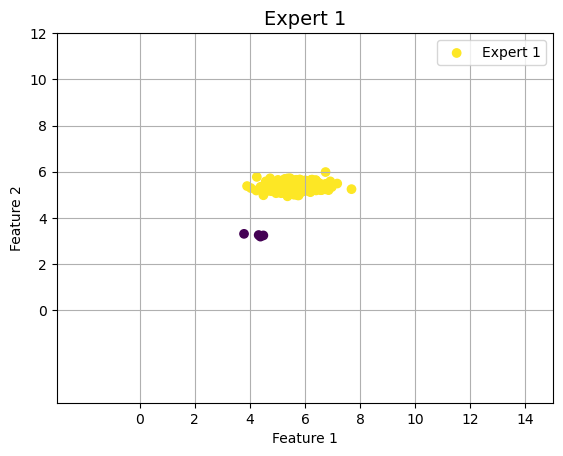

In [304]:
plt.title('Expert 1', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))

plt.xlim(-3, 15)
plt.ylim(-4, 12)

plt.scatter(X_train[exp1_index_train, 0], X_train[exp1_index_train, 1], c=(torch.tensor(expert1(X_train[exp1_index_train])) == y_train[exp1_index_train])*1, label = 'Expert 1')
plt.legend()
plt.grid(True)
plt.show()

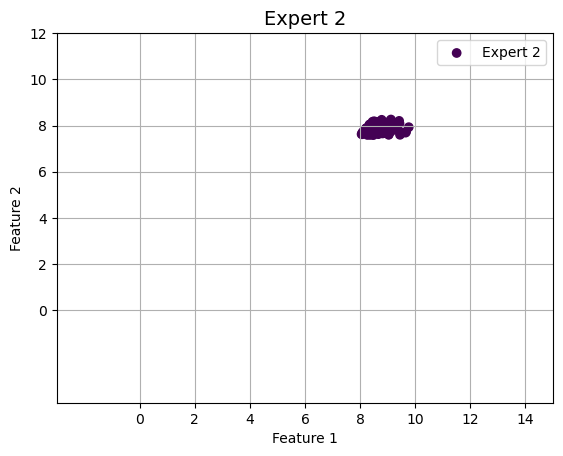

In [305]:
plt.title('Expert 2', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))

plt.xlim(-3, 15)
plt.ylim(-4, 12)

plt.scatter(X_train[exp2_index_train, 0], X_train[exp2_index_train, 1], c=(torch.tensor(expert2(X_train[exp2_index_train])) == y_train[exp2_index_train])*1, label = 'Expert 2')
plt.legend()
plt.grid(True)
plt.show()

In [306]:
# keep track of what in/correct instances are deferred to each expert by index and inputs
exp_index = [[] for _ in range(k)]

exp1_index, exp2_index = classifier_rej_id(m, experts, X_test, y_test, k, exp_index)

system accuracy 70.75
total points: 400

Expert 1 defer count: 112
Expert 1 defer percent: 28.0
Expert 1 correct predictions: 111
Expert 1 accuracy: 99.10696588041806

Expert 2 defer count: 55
Expert 2 defer percent: 13.75
Expert 2 correct predictions: 55
Expert 2 accuracy: 99.99963636495868

Not deferred to any expert count: 233
Not deferred percent: 58.25
Model correct predictions: 117
Model accuracy: 50.214570723360204


Overall expert count: 167
Overall expert defer percent: 41.75
Overall expert correct predictions: 166
Overall expert accuracy: 99.40113808315084


/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/3250963421.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_x)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/3250963421.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data_y)


- overall system accuracy okay, experts deferred on half of instances, experts perform very well but AI performs poor

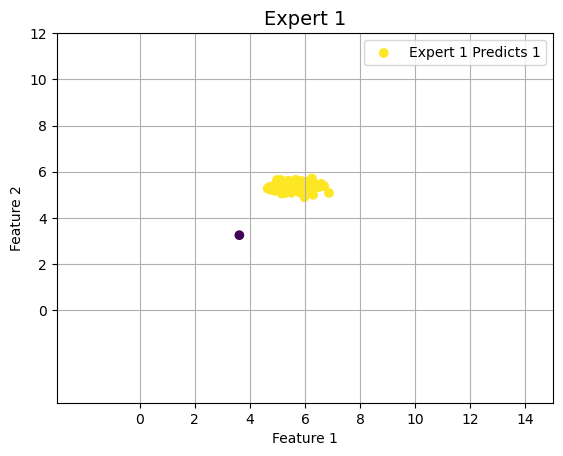

In [307]:
plt.title('Expert 1', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))

plt.xlim(-3, 15)
plt.ylim(-4, 12)

plt.scatter(X_test[exp1_index, 0], X_test[exp1_index, 1], c=(torch.tensor(expert1(X_test[exp1_index])) == y_test[exp1_index])*1, label = 'Expert 1 Predicts 1')
plt.legend()
plt.grid(True)
plt.show()

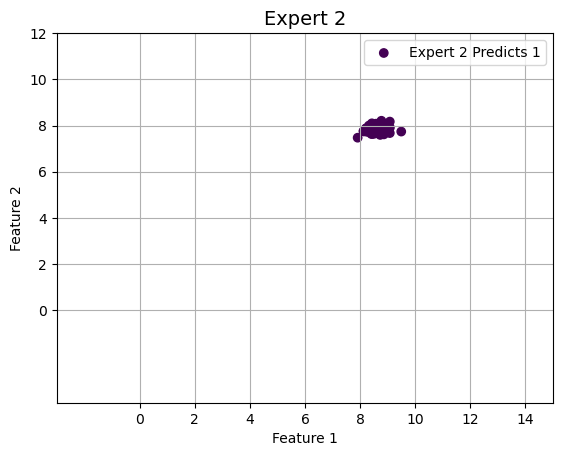

In [308]:
plt.title('Expert 2', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))

plt.xlim(-3, 15)
plt.ylim(-4, 12)

plt.scatter(X_test[exp2_index, 0], X_test[exp2_index, 1], c=(torch.tensor(expert2(X_test[exp2_index])) == y_test[exp2_index])*1, label = 'Expert 2 Predicts 1')
plt.legend()
plt.grid(True)
plt.show()

## Non-identity/Standard
- we expect to see the overall system performance ~ 50% and lower than the optimal approach

/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/1138102870.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_x)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/1138102870.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data_y)


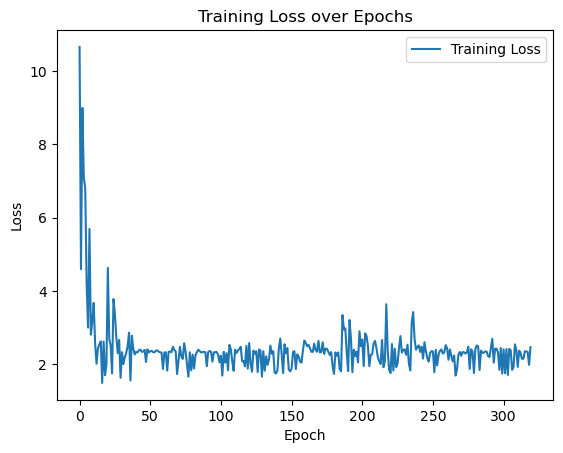

system accuracy 51.75
total points: 1600

Expert 1 defer count: 400
Expert 1 defer percent: 25.0
Expert 1 correct predictions: 196
Expert 1 accuracy: 48.99997550001225

Expert 2 defer count: 389
Expert 2 defer percent: 24.3125
Expert 2 correct predictions: 205
Expert 2 accuracy: 52.69920169706854

Not deferred to any expert count: 811
Not deferred percent: 50.6875
Model correct predictions: 427
Model accuracy: 52.65104159666565

Overall expert count: 789
Overall expert defer percent: 49.3125
Overall expert correct predictions: 401
Overall expert accuracy: 50.82382118836234


/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/2888274674.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_x)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/2888274674.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data_y)


In [309]:
m = Linear_net_rej(d,2) # 2 inputs
alpha = 0
p = 0.5

run_classifier_rej(m, experts, X_train, y_train, alpha, p, k)

exp1_index_train, exp2_index_train = classifier_rej(m, experts, X_train, y_train, p, k, exp_index)

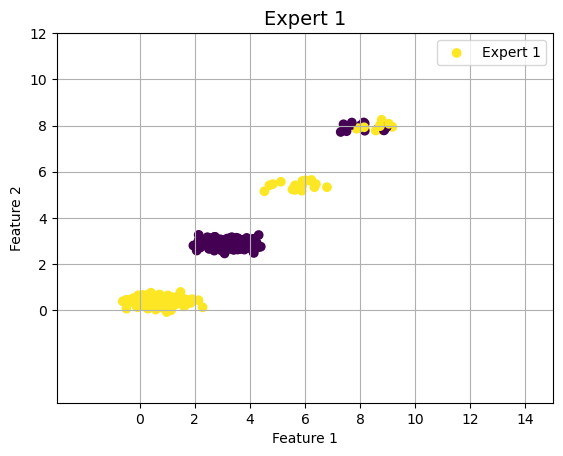

In [310]:
plt.title('Expert 1', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))

plt.xlim(-3, 15)
plt.ylim(-4, 12)

plt.scatter(X_train[exp1_index_train, 0], X_train[exp1_index_train, 1], c=(torch.tensor(expert1(X_train[exp1_index_train])) == y_train[exp1_index_train])*1, label = 'Expert 1')
plt.legend()
plt.grid(True)
plt.show()

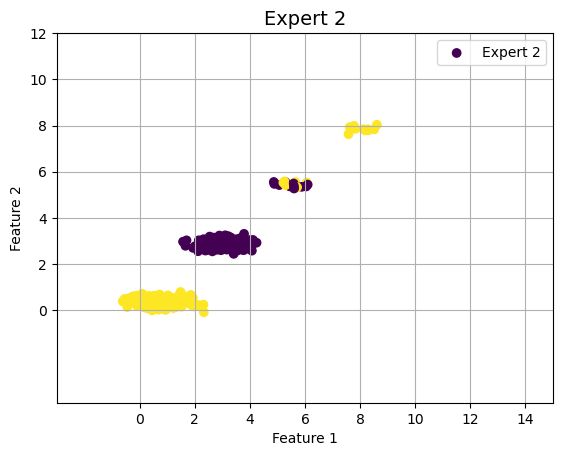

In [311]:
plt.title('Expert 2', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))

plt.xlim(-3, 15)
plt.ylim(-4, 12)

plt.scatter(X_train[exp2_index_train, 0], X_train[exp2_index_train, 1], c=(torch.tensor(expert2(X_train[exp2_index_train])) == y_train[exp2_index_train])*1, label = 'Expert 2')
plt.legend()
plt.grid(True)
plt.show()

In [312]:
# keep track of what in/correct instances are deferred to each expert by index and inputs
exp_index = [[] for _ in range(k)]

exp1_index, exp2_index = classifier_rej(m, experts, X_test, y_test, p, k, exp_index)

system accuracy 51.75
total points: 400

Expert 1 defer count: 95
Expert 1 defer percent: 23.75
Expert 1 correct predictions: 50
Expert 1 accuracy: 52.63146814427759

Expert 2 defer count: 97
Expert 2 defer percent: 24.25
Expert 2 correct predictions: 49
Expert 2 accuracy: 50.51535976214482

Not deferred to any expert count: 208
Not deferred percent: 52.0
Model correct predictions: 108
Model accuracy: 51.92305196007117

Overall expert count: 192
Overall expert defer percent: 48.0
Overall expert correct predictions: 99
Overall expert accuracy: 51.56247314454524


/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/2888274674.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_x)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/2888274674.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data_y)


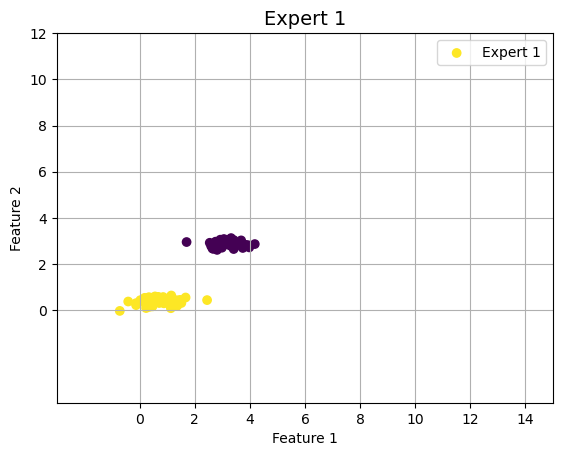

In [313]:
plt.title('Expert 1', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))

plt.xlim(-3, 15)
plt.ylim(-4, 12)

plt.scatter(X_test[exp1_index, 0], X_test[exp1_index, 1], c=(torch.tensor(expert1(X_test[exp1_index])) == y_test[exp1_index])*1, label = 'Expert 1')
plt.legend()
plt.grid(True)
plt.show()

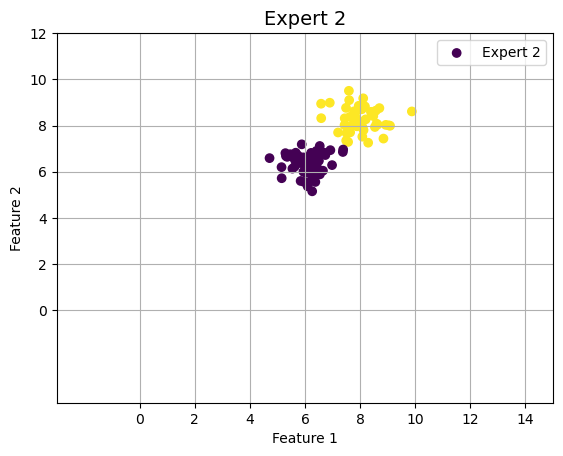

In [268]:
plt.title('Expert 2', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))

plt.xlim(-3, 15)
plt.ylim(-4, 12)

plt.scatter(X_test[exp2_index, 0], X_test[exp2_index, 1], c=(torch.tensor(expert2(X_test[exp2_index])) == y_test[exp2_index])*1, label = 'Expert 2')
plt.legend()
plt.grid(True)
plt.show()

# Varying data distributions for identity/optimal approach
- We can vary the training and testing data distributions
- In the simplest case test= train distribution. We expect accuracies to be ~100%
- We can illustrate distribution shifts when test != train distribution. We expect the model to not know how to route and performance will decrease but unclear how much and what component will decrease


In [317]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=456)

/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/2435080426.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_x)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/2435080426.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data_y)


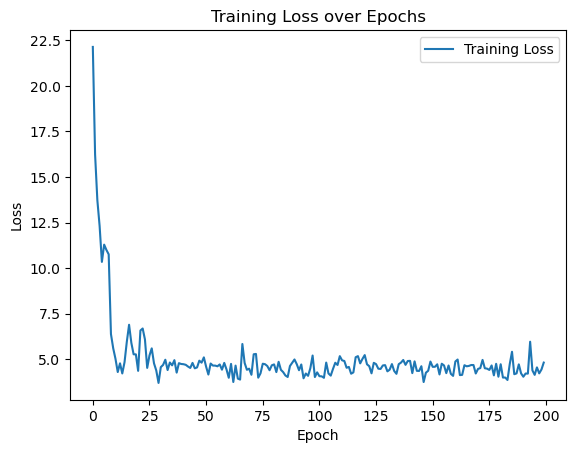

system accuracy 67.0
total points: 1000

Expert 1 defer count: 266
Expert 1 defer percent: 26.6
Expert 1 correct predictions: 246
Expert 1 accuracy: 92.48113347283197

Expert 2 defer count: 129
Expert 2 defer percent: 12.9
Expert 2 correct predictions: 129
Expert 2 accuracy: 99.99984496148068

Not deferred to any expert count: 605
Not deferred percent: 60.5
Model correct predictions: 295
Model accuracy: 48.76032251895496


Overall expert count: 395
Overall expert defer percent: 39.5
Overall expert correct predictions: 375
Overall expert accuracy: 94.93668482615574


/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/3250963421.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_x)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/3250963421.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data_y)


In [318]:
d = 2
experts = [expert1, expert2]
k = len(experts)
m = Linear_net_rej_id(d,2,k) # 2 inputs
alpha = 0

exp_index_train = [[] for _ in range(k)]

run_classifier_rej_id(m, experts, X_train, y_train, alpha, k)
exp1_index_train, exp2_index_train = classifier_rej_id(m, experts, X_train, y_train, k, exp_index_train)

In [319]:
# keep track of what in/correct instances are deferred to each expert by index and inputs
exp_index = [[] for _ in range(k)]

exp1_index, exp2_index = classifier_rej_id(m, experts, X_test, y_test, k, exp_index)

system accuracy 69.1
total points: 1000

Expert 1 defer count: 265
Expert 1 defer percent: 26.5
Expert 1 correct predictions: 254
Expert 1 accuracy: 95.84898426491753

Expert 2 defer count: 132
Expert 2 defer percent: 13.2
Expert 2 correct predictions: 132
Expert 2 accuracy: 99.99984848507805

Not deferred to any expert count: 603
Not deferred percent: 60.3
Model correct predictions: 305
Model accuracy: 50.58042278931629


Overall expert count: 397
Overall expert defer percent: 39.7
Overall expert correct predictions: 386
Overall expert accuracy: 97.22919465259581


/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/3250963421.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_x)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/3250963421.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data_y)


In [335]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=456)

/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/2435080426.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_x)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/2435080426.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data_y)


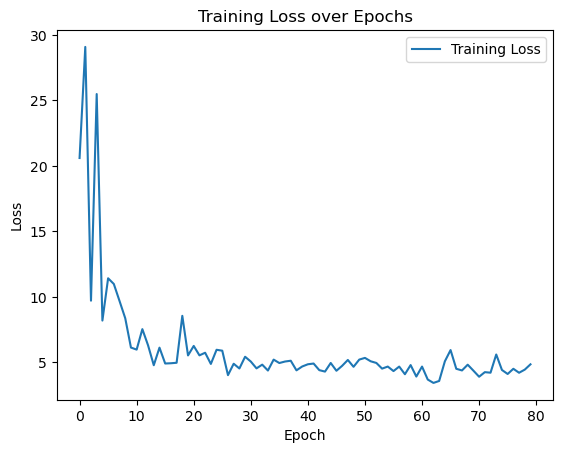

system accuracy 54.75
total points: 400

Expert 1 defer count: 134
Expert 1 defer percent: 33.5
Expert 1 correct predictions: 86
Expert 1 accuracy: 64.17900868804674

Expert 2 defer count: 48
Expert 2 defer percent: 12.0
Expert 2 correct predictions: 48
Expert 2 accuracy: 99.99958333506943

Not deferred to any expert count: 218
Not deferred percent: 54.5
Model correct predictions: 85
Model accuracy: 38.99080780238174


Overall expert count: 182
Overall expert defer percent: 45.5
Overall expert correct predictions: 134
Overall expert accuracy: 73.6263331723444


/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/3250963421.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_x)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/3250963421.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data_y)


In [336]:
d = 2
experts = [expert1, expert2]
k = len(experts)
m = Linear_net_rej_id(d,2,k) # 2 inputs
alpha = 0

exp_index_train = [[] for _ in range(k)]

run_classifier_rej_id(m, experts, X_train, y_train, alpha, k)
exp1_index_train, exp2_index_train = classifier_rej_id(m, experts, X_train, y_train, k, exp_index_train)

In [337]:
# keep track of what in/correct instances are deferred to each expert by index and inputs
exp_index = [[] for _ in range(k)]

exp1_index, exp2_index = classifier_rej_id(m, experts, X_test, y_test, k, exp_index)

system accuracy 61.375
total points: 1600

Expert 1 defer count: 553
Expert 1 defer percent: 34.5625
Expert 1 correct predictions: 414
Expert 1 accuracy: 74.86434905448498

Expert 2 defer count: 210
Expert 2 defer percent: 13.125
Expert 2 correct predictions: 210
Expert 2 accuracy: 99.99990476199547

Not deferred to any expert count: 837
Not deferred percent: 52.3125
Model correct predictions: 358
Model accuracy: 42.77179895199535


Overall expert count: 763
Overall expert defer percent: 47.6875
Overall expert correct predictions: 624
Overall expert accuracy: 81.78242702720485


/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/3250963421.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_x)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_16120/3250963421.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data_y)


knobs:
- change mean and sd for distributions
- change % of training data for each expert

# Diverse Experts

In [314]:
class LinearClassifier(torch.nn.Module):
    def __init__(self, input_dim):
        super(LinearClassifier, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

class MultiLinearClassifiers(torch.nn.Module):
    def __init__(self, input_dim, k):
        super(MultiLinearClassifiers, self).__init__()
        self.experts = torch.nn.ModuleList([LinearClassifier(input_dim) for _ in range(k)])
        self.slopes = torch.nn.Parameter(torch.randn(k))  # Adjustable slopes

    def forward(self, x):
        outputs = []
        for i, expert in enumerate(self.experts):
            output = expert(x) * self.slopes[i]  # Adjusting slope
            outputs.append(output)
        return torch.cat(outputs, dim=1)

In [315]:
def plot_experts_lines(model, slope):
    fig, ax = plt.subplots(figsize=(8, 6))
    colors = ['r', 'g', 'b', 'c', 'm']  # Color for each expert

    for i, expert in enumerate(model.experts):
        weight, bias = expert.linear.weight.squeeze().detach().numpy(), expert.linear.bias.item()
        if slope == 0:
            x = np.full(100, -bias / weight[0]) 
            y = np.linspace(-5, 5, 100) 
        else:
            x = np.linspace(-5, 5, 100)
            y = (slope * x - bias) / weight[1]  # y = mx + b
        ax.plot(x, y, label=f'Expert {i+1}', color=colors[i])

    ax.set_title('Experts Decision Boundaries')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()
    plt.grid(True)
    plt.show()

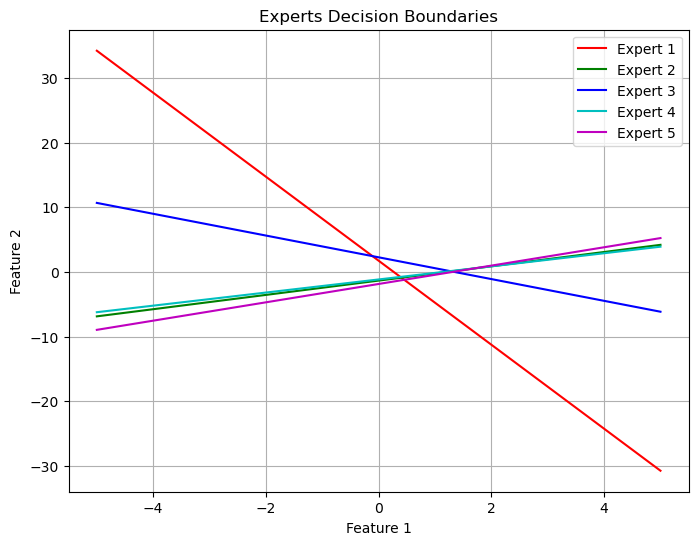

In [316]:

input_dim = 2
k = 5
model = MultiLinearClassifiers(input_dim, k)

slope = 0.5

plot_experts_lines(model, slope)